In [2]:
import re
import os
import pandas as pd
import matplotlib.pyplot as plot

In [3]:
tolerancias = ['0.050000', '0.035000', '0.025000', '0.020000']
path_root = '../testing_results/test_movimiento_'
df_list = []

Levantamos los datos

In [4]:
path = "../testing_results/test_movimiento_0.020000.txt"
df_entero = pd.read_csv(path, sep=';')

for tolerancia in tolerancias :
    path = path_root + tolerancia + '.txt'
    df_list.append(pd.read_csv(path, sep=';'))
print(df_list[3])

          base  shoulder     elbow     pitch      roll  is_end_pose  move_id  \
0     0.005190  1.483447 -0.000033  0.024106 -0.002124            0        0   
1     0.005190  1.483447 -0.000033  0.023722 -0.002124            0        0   
2    -0.041162  1.437253  0.030769 -0.007076  0.044098            0        0   
3    -0.035269  1.432281  0.030501  0.009916  0.043137            0        0   
4    -0.087514  1.391058  0.061571 -0.038259  0.090320            0        0   
...        ...       ...       ...       ...       ...          ...      ...   
2443  0.052119  1.457302 -0.034871  0.045464 -0.053711            0        0   
2444  0.055003  1.459952 -0.035009  0.064428 -0.054739            0        0   
2445 -0.000026  1.483473  0.000032  0.011034 -0.001394            1        0   
2446  0.002561  1.485720 -0.000099  0.030461 -0.002451            1        0   
2447  0.000000  0.000000  0.000000  0.000000  0.000000            2        3   

      time_elapsed  
0                0

Agregamos cual a que movimiento corresponde cada posición

In [5]:
def discriminar_movimientos_goals_reales_y_esperados(df) :

    arr_de_ceros = [0]*len(df)
    arr_de_ceros_2 = [0]*len(df)
    df_discriminando_movimientos = df.assign(num_goal=arr_de_ceros)
    df_discriminando_movimientos = df_discriminando_movimientos.assign(es_el_esperado=arr_de_ceros_2)


    num_movimiento = 1
    num_de_goal = 1
    es_real = False

    for i, row in df_discriminando_movimientos.iterrows():
        df_discriminando_movimientos.at[i, 'num_goal'] = num_de_goal
        
        ## primero vemos si es un marcador de movimiento (is_end_pose = 2)
        if(row['is_end_pose'] == 2) :
            num_movimiento = (row['move_id'] % 3) + 1
            df_discriminando_movimientos.at[i,'num_goal'] = 0
            df_discriminando_movimientos.at[i-1, 'time_elapsed'] = row['time_elapsed']
            df_discriminando_movimientos.at[i-2, 'time_elapsed'] = row['time_elapsed']
        else:
            ## si no es marcador, es un dato y ahí vemos si es real o deseado
            df_discriminando_movimientos.at[i, 'move_id'] = num_movimiento
            if(not es_real) :
                df_discriminando_movimientos.at[i, 'es_el_esperado'] = 1
                es_real = True
            else :
                es_real = False
                num_de_goal = num_de_goal + 1
                if (row['is_end_pose'] == 1) :
                    num_de_goal = 1

    df_discriminando_movimientos = df_discriminando_movimientos.query('is_end_pose != 2')

    return df_discriminando_movimientos


In [6]:
df_entero_discriminando_movimientos = discriminar_movimientos_goals_reales_y_esperados(df_entero)

df_list_movs = []

for df in df_list :
    df_list_movs.append(discriminar_movimientos_goals_reales_y_esperados(df))

In [7]:
df_list_poses_finales = []
for df in df_list_movs :
    df_list_poses_finales.append(df.query('is_end_pose == 1'))

In [8]:
df_list_reales = []
df_list_esperados = []
for df in df_list_poses_finales : 
    df_list_reales.append(df.query('es_el_esperado == 0').drop(['is_end_pose','num_goal','es_el_esperado', 'time_elapsed'],axis='columns'))
    df_list_esperados.append(df.query('es_el_esperado == 1').drop(['is_end_pose','num_goal','es_el_esperado', 'time_elapsed'],axis='columns'))
    
print(df_list_reales[3])

          base  shoulder     elbow     pitch      roll  move_id
69   -1.565445 -0.092416  1.044999 -1.018034  1.567813        1
182   1.564011  0.692337 -1.046908  1.038578 -1.570755        2
243   0.003619  1.485904  0.000066  0.030899 -0.002124        3
312  -1.567425 -0.092416  1.044835 -1.018198  1.567650        1
425   1.563943  0.698295 -1.046908  1.039236 -1.570264        2
486   0.002766  1.485812 -0.000033  0.030187 -0.002124        3
555  -1.564762 -0.092386  1.044901 -1.017376  1.567650        1
668   1.562952  0.692736 -1.046842  1.039290 -1.570755        2
729   0.006419  1.485751  0.000033  0.030078 -0.001797        3
800  -1.564591 -0.092816  1.045230 -1.016609  1.567977        1
913   1.563840  0.693012 -1.047006  1.038414 -1.570101        2
974   0.003209  1.485751 -0.000099  0.030899 -0.002124        3
1043 -1.566093 -0.093246  1.044901 -1.016390  1.567813        1
1156  1.564420  0.691262 -1.046842  1.039016 -1.570264        2
1219  0.007375  1.486211  0.000000  0.02

In [9]:
df_list_reales_primer_mov = []
df_list_reales_segundo_mov = []
df_list_reales_tercer_mov = []

df_list_esperados_primer_mov = []
df_list_esperados_segundo_mov = []
df_list_esperados_tercer_mov = []

for i in range(0,4) : 
    df_list_reales_primer_mov.append(df_list_reales[i].query('move_id == 1').drop(['move_id'], axis='columns'))
    df_list_reales_segundo_mov.append(df_list_reales[i].query('move_id == 2').drop(['move_id'], axis='columns'))
    df_list_reales_tercer_mov.append(df_list_reales[i].query('move_id == 3').drop(['move_id'], axis='columns'))

    df_list_esperados_primer_mov.append(df_list_esperados[i].query('move_id == 1').drop(['move_id'], axis='columns'))
    df_list_esperados_segundo_mov.append(df_list_esperados[i].query('move_id == 2').drop(['move_id'], axis='columns'))
    df_list_esperados_tercer_mov.append(df_list_esperados[i].query('move_id == 3').drop(['move_id'], axis='columns'))


In [10]:
df_list_error_primer_mov = []
df_list_error_segundo_mov = []
df_list_error_tercer_mov = []

def error_entre_listas_dfs (reales, esperados) :
    errores = []
    for i in range(0, len(reales)) :
        df_real = reales[i].reset_index(drop=True)
        df_esperado = esperados[i].reset_index(drop=True)
        errores.append((df_esperado - df_real).abs())
    return errores

df_list_error_primer_mov = error_entre_listas_dfs(df_list_reales_primer_mov, df_list_esperados_primer_mov)
df_list_error_segundo_mov = error_entre_listas_dfs(df_list_reales_segundo_mov, df_list_esperados_segundo_mov)
df_list_error_tercer_mov = error_entre_listas_dfs(df_list_reales_tercer_mov, df_list_esperados_tercer_mov)

print(df_list_error_tercer_mov[3])
    

       base  shoulder     elbow     pitch      roll
0  0.003516  0.002411  0.000110  0.019790  0.000730
1  0.002662  0.002336  0.000106  0.019186  0.000867
2  0.006419  0.002278  0.000102  0.018966  0.000403
3  0.003081  0.002223  0.000125  0.019845  0.000771
4  0.007308  0.002734  0.000102  0.018915  0.000473
5  0.004274  0.002639  0.000115  0.019406  0.001037
6  0.005504  0.002551  0.000111  0.019010  0.000723
7  0.003657  0.002656  0.000104  0.019088  0.001103
8  0.005521  0.002554  0.000065  0.019088  0.000561
9  0.002587  0.002247  0.000131  0.019427  0.001057


In [11]:
df_list_primer_mov_error_avg = []
df_list_segundo_mov_error_avg = []
df_list_tercer_mov_error_avg = []

df_list_primer_mov_error_var = []
df_list_segundo_mov_error_var = []
df_list_tercer_mov_error_var = []

def error_y_varianza_promedio_para_cada_df_de_una_lista(errores, promedios, varianzas) :
    for i in range(0, len(errores)) :
        promedios.append(errores[i].mean())
        varianzas.append(errores[i].var())

error_y_varianza_promedio_para_cada_df_de_una_lista(df_list_error_primer_mov, df_list_primer_mov_error_avg, df_list_primer_mov_error_var)
error_y_varianza_promedio_para_cada_df_de_una_lista(df_list_error_segundo_mov, df_list_segundo_mov_error_avg, df_list_segundo_mov_error_var)
error_y_varianza_promedio_para_cada_df_de_una_lista(df_list_error_tercer_mov, df_list_tercer_mov_error_avg, df_list_tercer_mov_error_var)

print(df_list_segundo_mov_error_avg[1])
print(df_list_segundo_mov_error_var[1])


base        0.007969
shoulder    0.006174
elbow       0.000182
pitch       0.026085
roll        0.001555
dtype: float64
base        6.733237e-06
shoulder    1.727158e-05
elbow       2.331511e-09
pitch       3.019582e-06
roll        5.080134e-08
dtype: float64


In [12]:
df_list_primer_mov_error_avg_porcentual = []
df_list_segundo_mov_error_avg_porcentual = []
df_list_tercer_mov_error_avg_porcentual = []



def error_porcentual_segun_tolerancia(errores, list_tolerancias, porcentuales) :
    for i in range(0, len(errores)) :
        porcentuales.append(errores[i] * 100 / float(list_tolerancias[i]))

error_porcentual_segun_tolerancia(df_list_primer_mov_error_avg, tolerancias, df_list_primer_mov_error_avg_porcentual)
error_porcentual_segun_tolerancia(df_list_segundo_mov_error_avg, tolerancias, df_list_segundo_mov_error_avg_porcentual)
error_porcentual_segun_tolerancia(df_list_tercer_mov_error_avg, tolerancias, df_list_tercer_mov_error_avg_porcentual)

print(df_list_tercer_mov_error_avg_porcentual[0])

base        89.9022
shoulder    20.0346
elbow        6.1264
pitch       73.0814
roll         1.8758
dtype: float64


/tmp/ipykernel_17076/1878927591.py:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  joint_errors_primer = pd.Series()
/tmp/ipykernel_17076/1878927591.py:12: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  joint_errors_segundo = pd.Series()
/tmp/ipykernel_17076/1878927591.py:13: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  joint_errors_tercer = pd.Series()
/tmp/ipykernel_17076/1878927591.py:20: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  joint_variance_primer = pd.Series()
/tmp/ipykernel_17076/1878927591.p

               1          2          3
0.05   88.422600  48.465000  89.902200
0.035  36.088571  22.769143  14.881143
0.025  43.251600  27.458000  20.676800
0.02   22.783000  34.275500  22.264500


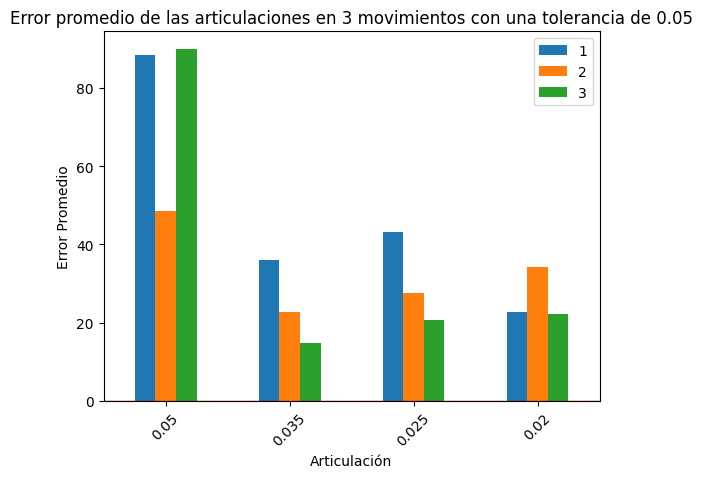

In [18]:
joints = ['base', 'shoulder', 'elbow', 'pitch', 'roll']
tols = ['0.05', '0.035', '0.025', '0.02']
df_list_errors_by_joint = []
df_list_variance_by_joint = []

def get_joint_avgs_by_tolerance(df_list_move, joint, serie) :
    for i in range(0,4) :
        serie.at[tols[i]] = df_list_move[i][joint]

for joint in joints :
    joint_errors_primer = pd.Series()
    joint_errors_segundo = pd.Series()
    joint_errors_tercer = pd.Series()
    get_joint_avgs_by_tolerance(df_list_primer_mov_error_avg_porcentual, joint, joint_errors_primer)
    get_joint_avgs_by_tolerance(df_list_segundo_mov_error_avg_porcentual, joint, joint_errors_segundo)
    get_joint_avgs_by_tolerance(df_list_tercer_mov_error_avg_porcentual, joint, joint_errors_tercer)

    df_list_errors_by_joint.append(pd.concat([joint_errors_primer.rename('1'), joint_errors_segundo.rename('2'), joint_errors_tercer.rename('3')], axis=1))
    
    joint_variance_primer = pd.Series()
    joint_variance_segundo = pd.Series()
    joint_variance_tercer = pd.Series()
    get_joint_avgs_by_tolerance(df_list_primer_mov_error_var, joint, joint_variance_primer)
    get_joint_avgs_by_tolerance(df_list_segundo_mov_error_var, joint, joint_variance_segundo)
    get_joint_avgs_by_tolerance(df_list_tercer_mov_error_var, joint, joint_variance_tercer)

    df_list_variance_by_joint.append(pd.concat([joint_variance_primer.rename('1'), joint_variance_segundo.rename('2'), joint_variance_tercer.rename('3')], axis=1))


print(df_list_errors_by_joint[0])


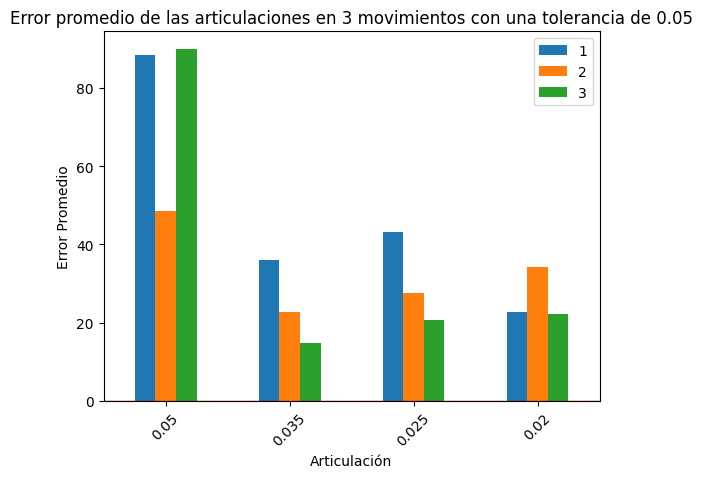

In [19]:
df_list_errors_by_joint[0].plot(kind='bar')
plot.title("Error promedio de las articulaciones en 3 movimientos con una tolerancia de 0.05")
plot.ylabel("Error Promedio")
plot.xlabel("Articulación")
plot.xticks(rotation=45, horizontalalignment="center")
plot.axhline(y=0.020, linewidth=1, color='red')

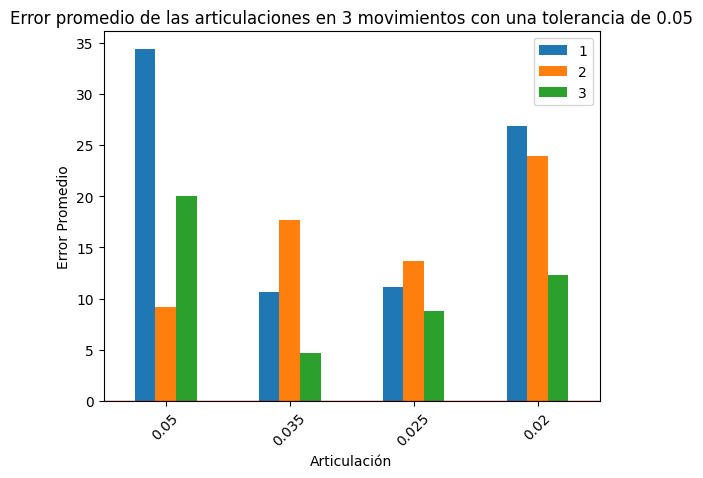

In [20]:
df_list_errors_by_joint[1].plot(kind='bar')
plot.title("Error promedio de las articulaciones en 3 movimientos con una tolerancia de 0.05")
plot.ylabel("Error Promedio")
plot.xlabel("Articulación")
plot.xticks(rotation=45, horizontalalignment="center")
plot.axhline(y=0.020, linewidth=1, color='red')

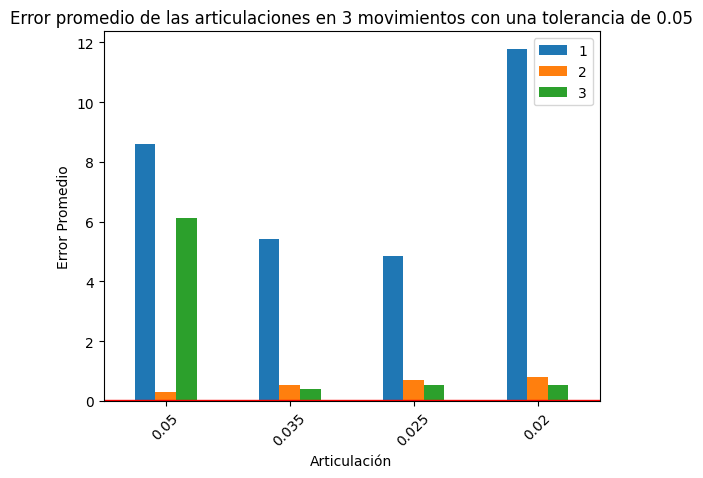

In [21]:
df_list_errors_by_joint[2].plot(kind='bar')
plot.title("Error promedio de las articulaciones en 3 movimientos con una tolerancia de 0.05")
plot.ylabel("Error Promedio")
plot.xlabel("Articulación")
plot.xticks(rotation=45, horizontalalignment="center")
plot.axhline(y=0.020, linewidth=1, color='red')

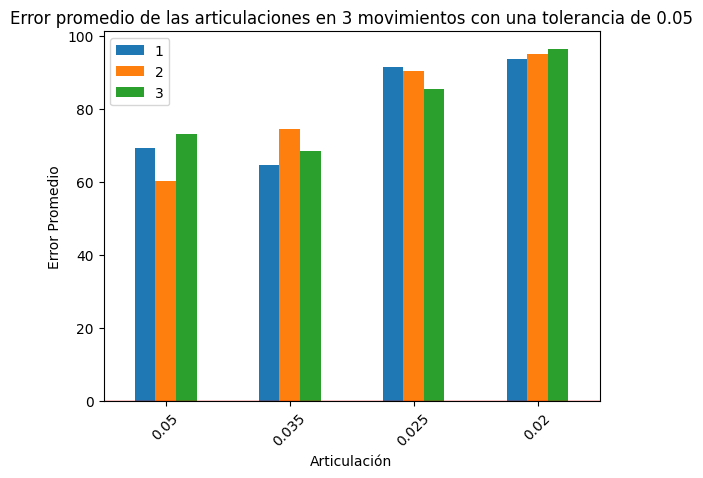

In [22]:
df_list_errors_by_joint[3].plot(kind='bar')
plot.title("Error promedio de las articulaciones en 3 movimientos con una tolerancia de 0.05")
plot.ylabel("Error Promedio")
plot.xlabel("Articulación")
plot.xticks(rotation=45, horizontalalignment="center")
plot.axhline(y=0.020, linewidth=1, color='red')

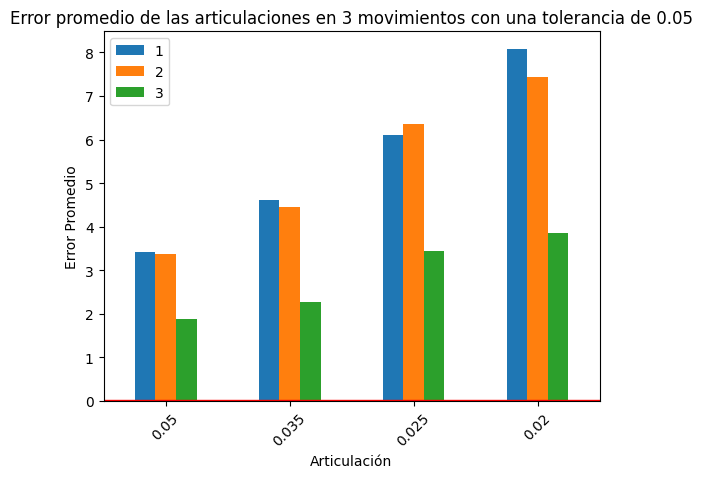

In [23]:
df_list_errors_by_joint[4].plot(kind='bar')
plot.title("Error promedio de las articulaciones en 3 movimientos con una tolerancia de 0.05")
plot.ylabel("Error Promedio")
plot.xlabel("Articulación")
plot.xticks(rotation=45, horizontalalignment="center")
plot.axhline(y=0.020, linewidth=1, color='red')

In [18]:
df_primer_mov = df_entero_discriminando_movimientos.query('move_id == 1')
df_segundo_mov = df_entero_discriminando_movimientos.query('move_id == 2')
df_tercer_mov = df_entero_discriminando_movimientos.query('move_id == 3')

df_primer_mov_real = df_primer_mov.query('es_el_esperado == 0')
df_primer_mov_esperado = df_primer_mov.query('es_el_esperado == 1')

df_segundo_mov_real = df_segundo_mov.query('es_el_esperado == 0')
df_segundo_mov_esperado = df_segundo_mov.query('es_el_esperado == 1')

df_tercer_mov_real = df_tercer_mov.query('es_el_esperado == 0')
df_tercer_mov_esperado = df_tercer_mov.query('es_el_esperado == 1')

In [19]:
print(df_primer_mov_real.get('num_goal').value_counts())
print(df_segundo_mov_real.get('num_goal').value_counts())
print(df_tercer_mov_real.get('num_goal').value_counts())

1     10
27    10
21    10
22    10
23    10
24    10
25    10
26    10
28    10
19    10
29    10
30    10
31    10
32    10
33    10
34    10
20    10
18    10
2     10
9     10
3     10
4     10
5     10
6     10
7     10
8     10
10    10
17    10
11    10
12    10
13    10
14    10
15    10
16    10
35     5
Name: num_goal, dtype: int64
1     10
2     10
31    10
32    10
33    10
34    10
35    10
36    10
37    10
38    10
39    10
40    10
41    10
42    10
43    10
44    10
45    10
46    10
47    10
48    10
49    10
50    10
51    10
52    10
53    10
54    10
55    10
30    10
29    10
28    10
14    10
3     10
4     10
5     10
6     10
7     10
8     10
9     10
10    10
11    10
12    10
13    10
15    10
27    10
16    10
17    10
18    10
19    10
20    10
21    10
22    10
23    10
24    10
25    10
26    10
56    10
Name: num_goal, dtype: int64
1     10
17    10
30    10
29    10
28    10
27    10
26    10
25    10
24    10
23    10
22    10
21    10
20    10
19    

In [20]:
df_primer_mov_real = df_primer_mov_real.query('is_end_pose == 1')
print(df_primer_mov_real)
df_segundo_mov_real = df_segundo_mov_real.query('is_end_pose == 1')
df_tercer_mov_real = df_tercer_mov_real.query('is_end_pose == 1')

          base  shoulder     elbow     pitch      roll  is_end_pose  move_id  \
69   -1.565445 -0.092416  1.044999 -1.018034  1.567813            1        1   
312  -1.567425 -0.092416  1.044835 -1.018198  1.567650            1        1   
555  -1.564762 -0.092386  1.044901 -1.017376  1.567650            1        1   
800  -1.564591 -0.092816  1.045230 -1.016609  1.567977            1        1   
1043 -1.566093 -0.093246  1.044901 -1.016390  1.567813            1        1   
1290 -1.565957 -0.091648  1.044934 -1.017266  1.567977            1        1   
1533 -1.566913 -0.092386  1.044572 -1.018034  1.567813            1        1   
1780 -1.567596 -0.093030  1.044999 -1.016609  1.567977            1        1   
2025 -1.564864 -0.092539  1.044901 -1.016719  1.567813            1        1   
2270 -1.568005 -0.092662  1.044835 -1.018910  1.567813            1        1   

      time_elapsed  num_goal  es_el_esperado  
69              40        35               0  
312             40       

In [21]:
df_primer_mov_esperado = df_primer_mov_esperado.query('is_end_pose == 1')
print(df_primer_mov_esperado)
df_segundo_mov_esperado = df_segundo_mov_esperado.query('is_end_pose == 1')
df_tercer_mov_esperado = df_tercer_mov_esperado.query('is_end_pose == 1')

          base  shoulder     elbow     pitch      roll  is_end_pose  move_id  \
68   -1.570763 -0.087164  1.047231 -1.036089  1.569435            1        1   
311  -1.570714 -0.087180  1.047304 -1.036270  1.569417            1        1   
554  -1.570745 -0.087166  1.047310 -1.036086  1.569445            1        1   
799  -1.570672 -0.087146  1.047252 -1.036157  1.569477            1        1   
1042 -1.570693 -0.087223  1.047315 -1.036116  1.569406            1        1   
1289 -1.570710 -0.087141  1.047303 -1.036115  1.569476            1        1   
1532 -1.570765 -0.087152  1.047234 -1.036247  1.569481            1        1   
1779 -1.570708 -0.087318  1.047203 -1.036126  1.569499            1        1   
2024 -1.570776 -0.087129  1.047275 -1.036099  1.569423            1        1   
2269 -1.570671 -0.087135  1.047243 -1.036098  1.569392            1        1   

      time_elapsed  num_goal  es_el_esperado  
68              40        35               1  
311             40       

In [61]:
df_primer_mov_real_juntas = df_primer_mov_real.drop(['is_end_pose','move_id','num_goal','es_el_esperado'],axis='columns')
print(df_primer_mov_real_juntas)
df_segundo_mov_real_juntas = df_segundo_mov_real.drop(['is_end_pose','move_id','num_goal','es_el_esperado'],axis='columns')
df_tercer_mov_real_juntas = df_tercer_mov_real.drop(['is_end_pose','move_id','num_goal','es_el_esperado'],axis='columns')

df_primer_mov_esperado_juntas = df_primer_mov_esperado.drop(['is_end_pose','move_id','num_goal','es_el_esperado'],axis='columns')
print(df_primer_mov_esperado_juntas)
df_segundo_mov_esperado_juntas = df_segundo_mov_esperado.drop(['is_end_pose','move_id','num_goal','es_el_esperado'],axis='columns')
df_tercer_mov_esperado_juntas = df_tercer_mov_esperado.drop(['is_end_pose','move_id','num_goal','es_el_esperado'],axis='columns')


          base  shoulder     elbow     pitch      roll
69   -1.564455 -0.092048  1.044999 -1.021978  1.567160
316  -1.565445 -0.092754  1.044934 -1.022526  1.566996
561  -1.568108 -0.092631  1.045065 -1.019239  1.567323
808  -1.567971 -0.092662  1.044934 -1.019677  1.567160
1053 -1.565138 -0.092570  1.044901 -1.019677  1.567160
1300 -1.567220 -0.092508  1.044901 -1.019896  1.567323
1547 -1.566810 -0.092355  1.044736 -1.022416  1.566996
1792 -1.565718 -0.093215  1.044999 -1.019567  1.566996
2039 -1.565991 -0.092170  1.044901 -1.022690  1.567323
2282 -1.568142 -0.092293  1.044802 -1.021321  1.567160
          base  shoulder     elbow     pitch      roll
68   -1.570809 -0.087169  1.047163 -1.038525  1.569490
315  -1.570857 -0.087256  1.047149 -1.038529  1.569406
560  -1.570765 -0.087278  1.047313 -1.038528  1.569491
807  -1.570862 -0.087234  1.047148 -1.038589  1.569433
1052 -1.570797 -0.087194  1.047173 -1.038536  1.569390
1299 -1.570935 -0.087165  1.047199 -1.038513  1.569505
1546 -1.57

In [62]:
df_error_primer_mov = df_primer_mov_esperado_juntas.reset_index(drop=True) - df_primer_mov_real_juntas.reset_index(drop=True)
print(df_error_primer_mov)
df_error_segundo_mov = df_segundo_mov_esperado_juntas.reset_index(drop=True) - df_segundo_mov_real_juntas.reset_index(drop=True)
df_error_tercer_mov = df_primer_mov_esperado_juntas.reset_index(drop=True) - df_primer_mov_real_juntas.reset_index(drop=True)

       base  shoulder     elbow     pitch      roll
0 -0.006354  0.004879  0.002164 -0.016547  0.002330
1 -0.005412  0.005498  0.002215 -0.016003  0.002410
2 -0.002657  0.005353  0.002248 -0.019289  0.002168
3 -0.002891  0.005428  0.002214 -0.018912  0.002273
4 -0.005659  0.005376  0.002272 -0.018859  0.002230
5 -0.003715  0.005343  0.002298 -0.018617  0.002182
6 -0.004014  0.005164  0.002431 -0.016126  0.002450
7 -0.005124  0.005913  0.002132 -0.019026  0.002452
8 -0.004789  0.004903  0.002264 -0.015807  0.002154
9 -0.002667  0.005124  0.002341 -0.017203  0.002381


In [63]:
df_error_primer_mov_avg = df_error_primer_mov.abs().mean()
df_error_primer_mov_var = df_error_primer_mov.abs().var()

df_error_segundo_mov_avg = df_error_segundo_mov.abs().mean()
df_error_segundo_mov_var = df_error_segundo_mov.abs().var()

df_error_tercer_mov_avg = df_error_tercer_mov.abs().mean()
df_error_tercer_mov_var = df_error_tercer_mov.abs().var()


                 1         2         3
base      0.004328  0.006654  0.004328
shoulder  0.005298  0.005380  0.005298
elbow     0.002258  0.000194  0.002258
pitch     0.017639  0.018848  0.017639
roll      0.002303  0.000717  0.002303


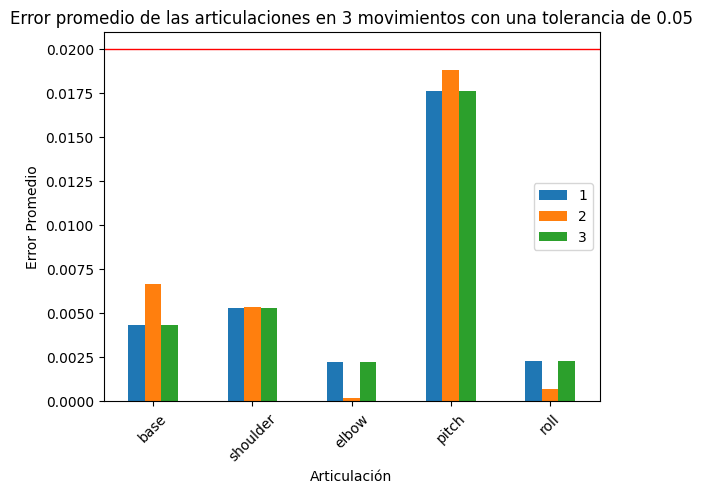

In [65]:
df_errores_avg = pd.concat([df_error_primer_mov_avg.rename('1'), df_error_segundo_mov_avg.rename('2'), df_error_tercer_mov_avg.rename('3')], axis=1)
print(df_errores_avg)

df_errores_avg.plot(kind='bar')
plot.title("Error promedio de las articulaciones en 3 movimientos con una tolerancia de 0.05")
plot.ylabel("Error Promedio")
plot.xlabel("Articulación")
plot.xticks(rotation=45, horizontalalignment="center")
plot.axhline(y=0.020, linewidth=1, color='red')
